In [4]:
import numpy as np
import pandas as pd

from src.constant import DATA_DIR, DATABASE_DIR
from src.database import DB
from src.database.queries import *
from src.instance.InstanceList import InstanceList
from src.instance.TSP_Instance import TSP_from_index_file
from src.solver.TSP_LKH_Solver import TSP_LKH_Solver

In [6]:
generators = [
    "cluster_netgen",
    "compression",
    "expansion",
    "explosion",
    "grid",
    "cluster",
    "implosion",
    "linearprojection",
    "rotation",
    "uniform_portgen",
]

test_instances = TSP_from_index_file(filepath=DATA_DIR / "TSP" / "TEST" / "index.json")

id_to_generator_name = {
    instance.id(): instance.filepath.parts[-2] for instance in test_instances
}

id_to_name = {
    instance.id(): instance.filepath.parts[-1] for instance in test_instances
}

In [7]:
def agg_prefix(prefix):

    frames = []

    def agg_cost(x):
        count = x.shape[0]
        x = x[x < TSP_LKH_Solver.MAX_COST]
        x = x.sort_values()
        idx = count // 2
        if x.shape[0] <= idx:
            return x.iloc[-1]
        return x.iloc[idx]
        

    for idx, db_path in enumerate(DATABASE_DIR.glob(f"{prefix}-*.db")):
        db = DB(db_path)
        results = pd.read_sql_query("SELECT * FROM results", db._conn)
        series = (
            results.loc[results["prefix"].str.startswith("test")]
            .groupby(["instance_id", "prefix"])["cost"]
            .min()
            .reset_index()
            .groupby("instance_id")["cost"]
            .agg(agg_cost)
        )
        frames.append(series)
        

    df = (
        pd.concat(frames, axis=1)
        .mean(axis=1)
        .round(3)
        .rename(prefix)
        .to_frame()
    )

    df["generator"] = df.index.map(id_to_generator_name)
    df["name"] = df.index.map(id_to_name)
    df = df.pivot_table(index="generator", columns="name", values=prefix).loc[generators, :]
    return df

n = 30
plain = agg_prefix(f"run-plain-{n}")
# sur25 = agg_prefix(f"run-{n}-sur-25")
# sur50 = agg_prefix(f"run-{n}-sur-50")
# sur75 = agg_prefix(f"run-{n}-sur-75")

plain = plain.assign(generator=f"plain-{n}").set_index("generator", append=True)
# sur25 = sur25.assign(generator="surrogate-25").set_index("generator", append=True)
# sur50 = sur50.assign(generator="surrogate-50").set_index("generator", append=True)
# sur75 = sur75.assign(generator="surrogate-75").set_index("generator", append=True)

In [8]:
plain

,name,000.tsp,001.tsp,002.tsp,003.tsp,004.tsp
generator,generator,,,,,
cluster_netgen,plain-30,0.105,0.170,0.190,0.160,1.995
compression,plain-30,0.095,0.090,1.950,0.070,0.075
expansion,plain-30,0.205,0.105,0.185,0.200,0.075
explosion,plain-30,1.900,0.090,0.060,0.110,0.105
grid,plain-30,0.190,0.115,0.085,0.130,0.080
cluster,plain-30,0.180,0.085,0.090,0.100,0.090
implosion,plain-30,0.045,0.075,1.965,0.195,0.055
linearprojection,plain-30,0.080,1.925,0.210,0.060,0.100
rotation,plain-30,0.180,2.400,0.070,0.115,0.065


In [20]:
df = pd.concat([plain, sur25, sur50, sur75], axis=0).sort_index(level=0).loc[generators]   
df["mean"] = df.mean(axis=1)

In [21]:
df.style.background_gradient(cmap="Reds", vmin=0, vmax=5).format("{:.3f}")

In [22]:
plain_total_mean = plain.mean(axis=1).mean(axis=0)
sur25_total_mean = sur25.mean(axis=1).mean(axis=0)
sur50_total_mean = sur50.mean(axis=1).mean(axis=0)
sur75_total_mean = sur75.mean(axis=1).mean(axis=0)
print(f"{plain_total_mean=:.3f}")
print(f"{sur25_total_mean=:.3f}")
print(f"{sur50_total_mean=:.3f}")
print(f"{sur75_total_mean=:.3f}")

plain_total_mean=0.533
sur25_total_mean=0.546
sur50_total_mean=0.578
sur75_total_mean=0.737


In [23]:
plain_training = plain.iloc[:5].mean(axis=1).mean(axis=0)
sur25_training = sur25.iloc[:5].mean(axis=1).mean(axis=0)
sur50_training = sur50.iloc[:5].mean(axis=1).mean(axis=0)
sur75_training = sur75.iloc[:5].mean(axis=1).mean(axis=0)

plain_not_training = plain.iloc[5:].mean(axis=1).mean(axis=0)
sur25_not_training = sur25.iloc[5:].mean(axis=1).mean(axis=0)
sur50_not_training = sur50.iloc[5:].mean(axis=1).mean(axis=0)
sur75_not_training = sur75.iloc[5:].mean(axis=1).mean(axis=0)

print(f"{plain_training=:.3f}", f"{plain_not_training=:.3f}")
print(f"{sur25_training=:.3f}", f"{sur25_not_training=:.3f}")
print(f"{sur50_training=:.3f}", f"{sur50_not_training=:.3f}")
print(f"{sur75_training=:.3f}", f"{sur75_not_training=:.3f}")

plain_training=0.489 plain_not_training=0.577
sur25_training=0.569 sur25_not_training=0.522
sur50_training=0.560 sur50_not_training=0.595
sur75_training=0.691 sur75_not_training=0.783


In [24]:
# 
df.to_excel("tmp.xlsx")

In [54]:
times = {}

for idx, db_path in enumerate(DATABASE_DIR.glob(f"{PREFIX}-*.db")):
    db = DB(db_path)
    results = pd.read_sql_query("SELECT * FROM results", db._conn)
    times[idx] = results.loc[
        results["prefix"].str.startswith("config")
        & results["cached"].eq(0)
        & results["surrogate"].eq(0),
        "time",
    ].sum()
    
np.round(pd.Series(times).mean(), 2)

20640.65

In [55]:
pd.Series(times).mean() / 3600

5.73351327659766

In [9]:
def agg_cost(x):
    count = x.shape[0]
    x = x[x < TSP_LKH_Solver.MAX_COST]
    x = x.sort_values()
    idx = count // 2
    if x.shape[0] <= idx:
        return x.iloc[-1]
    return x.iloc[idx]

for idx, db_path in enumerate(DATABASE_DIR.glob(f"run-500-sur-25-*.db")):
    db = DB(db_path)
    results = pd.read_sql_query("SELECT * FROM results", db._conn)
    series = (
        results.loc[results["prefix"].str.startswith("test")]
        .groupby(["instance_id", "prefix"])["cost"]
        .min()
        .reset_index()
        .groupby("instance_id")["cost"]
        .agg(agg_cost)
    )
    print(db_path, series.mean())

C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-500-sur-25-974816.db 0.04020000000000001
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-500-sur-25-974817.db 0.06520000000000001
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-500-sur-25-974818.db 0.044000000000000004
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-500-sur-25-974819.db 0.0394
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-500-sur-25-974820.db 0.042400000000000014
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-500-sur-25-974821.db 0.064
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-500-sur-25-974822.db 0.048600000000000004
C:\Users\zakrz\Documents\DataScience\praca magister

In [34]:
def agg_cost(x):
    count = x.shape[0]
    x = x[x < TSP_LKH_Solver.MAX_COST]
    x = x.sort_values()
    idx = count // 2
    if x.shape[0] <= idx:
        return x.iloc[-1]
    return x.iloc[idx]

for idx, db_path in enumerate(DATABASE_DIR.glob(f"run-plain-500-*.db")):
    db = DB(db_path)
    results = pd.read_sql_query("SELECT * FROM results", db._conn)
    series = (
        results.loc[results["prefix"].str.startswith("test")]
        .groupby(["instance_id", "prefix"])["cost"]
        .min()
        .reset_index()
        .groupby("instance_id")["cost"]
        .agg(agg_cost)
    )
    frame = series.to_frame()
    frame["generator"] = frame.index.map(id_to_generator_name)
    frame["name"] = frame.index.map(id_to_name)
    v = frame.loc[(frame["generator"] == "compression") & (frame["name"] == "001.tsp"), "cost"].iloc[0]
    print(db_path, v)

C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-plain-500-951743.db 0.39
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-plain-500-951744.db 0.14
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-plain-500-951745.db 0.4
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-plain-500-951746.db 0.05
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-plain-500-951747.db 0.24
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-plain-500-951748.db 0.1
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-plain-500-951749.db 0.05
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\database\run-plain-500-951750.db 0.18
C:\Users\zakrz\Doc

In [42]:
frame.loc[(frame["generator"] == "compression") & (frame["name"] == "001.tsp")]

,cost,generator,name
instance_id,,,
977323839173739137,0.13,compression,001.tsp


(0.0, 10.0)

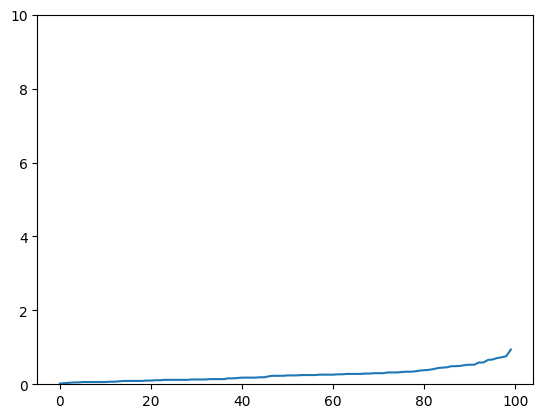

In [54]:
db_path = DATABASE_DIR / "run-plain-500-951747.db"
db = DB(db_path)
results = pd.read_sql_query("SELECT * FROM results", db._conn)
_ = results.loc[results["instance_id"] == "977323839173739137"].groupby(["instance_id", "prefix"])["cost"].min().reset_index()
import matplotlib.pyplot as plt
plt.plot(range(100), _.sort_values(by="cost")["cost"])
# plt.plot(range(100), _["cost"])
plt.ylim(0, 10)
# plt.plot([50], _.at[50, "cost"], "ro")
# _.sort_values(by="cost")